In [1]:
import pickle
import warnings
import random
import umap
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict
from scipy.spatial import distance
from scipy import stats
from sklearn import decomposition

from torch.nn import functional as F

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [4]:
embeds, rows = [], []

for path in tqdm(glob('../../data/b13-embeds/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 99/99 [00:40<00:00,  3.26it/s]


In [5]:
embeds = np.stack(embeds)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df.label.unique()

array(['dailycaller.com', 'thehill.com', 'bloomberg.com', 'breitbart.com',
       'buzzfeed.com', 'cnn.com', 'nytimes.com', 'apnews.com',
       'huffingtonpost.com', 'washingtonpost.com', 'wsj.com',
       'foxnews.com', 'dailykos.com'], dtype=object)

In [8]:
embeds.shape

(982833, 512)

In [9]:
def sampled_pw_ds(d, n=100000):
    
    d_embeds = embeds[df[df.label==d].index]
    
    idx1 = np.random.choice(range(len(d_embeds)), n)
    idx2 = np.random.choice(range(len(d_embeds)), n)
    
    x1 = torch.from_numpy(d_embeds[idx1])
    x2 = torch.from_numpy(d_embeds[idx2])
    
    ds = F.cosine_similarity(x1, x2)
    
    return ds.numpy()

In [10]:
domains = df.label.unique()

In [11]:
ds = {
    d: sampled_pw_ds(d, 500000)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [00:41<00:00,  2.94s/it]


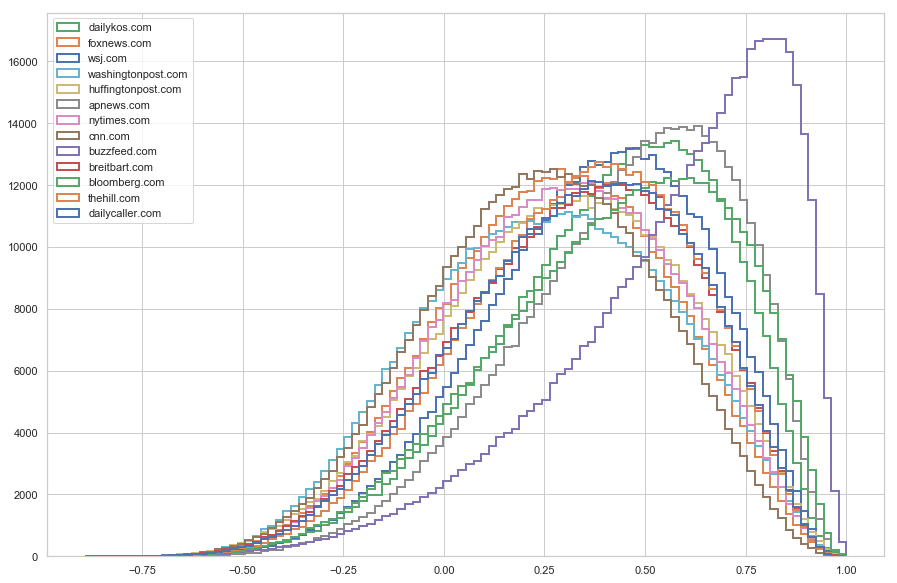

In [12]:
plt.figure(figsize=(15,10))
ys, x, _ = plt.hist(ds.values(), histtype='step', bins=100, linewidth=2, label=ds.keys())
plt.legend(loc='upper left')

In [13]:
rows = []
for y, domain in zip(ys, ds.keys()):
    for d, count in zip(x[:-1], y):
        rows.append((domain, d, count))
    
hist_df = pd.DataFrame(rows, columns=('domain', 'd', 'count'))

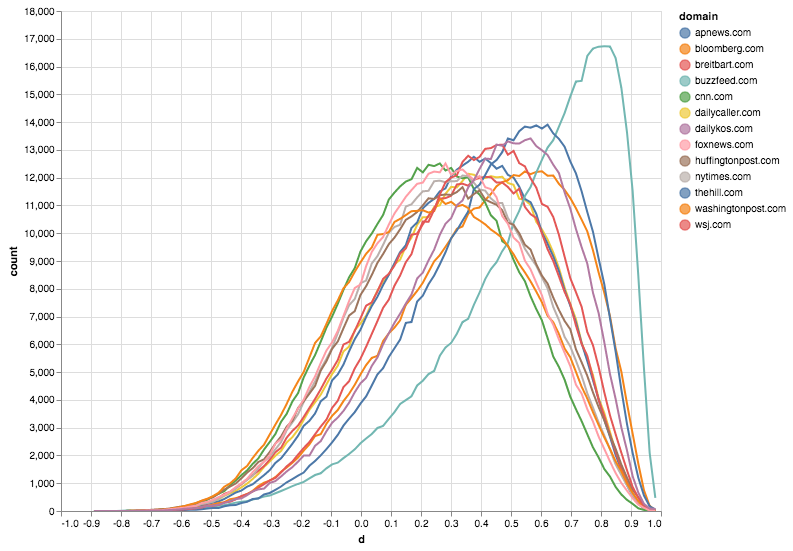

In [14]:
highlight = alt.selection(
    type='single',
    on='mouseover',
    fields=['domain'],
    nearest=True,
)

base = (alt
    .Chart(hist_df, width=700, height=500)
    .encode(x='d', y='count', color='domain'))

points = (base
    .mark_circle()
    .encode(opacity=alt.value(0))
    .add_selection(highlight)
    .properties(width=600))

lines = (base
    .mark_line()
    .encode(size=alt.condition(~highlight, alt.value(2), alt.value(5)), tooltip='domain'))

points + lines

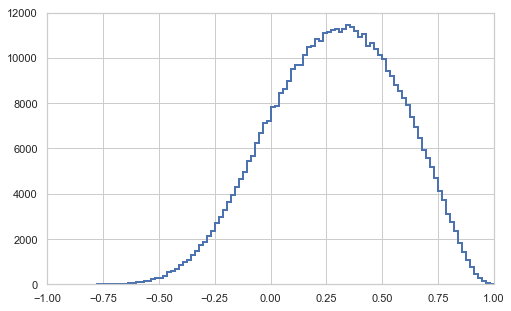

In [15]:
plt.figure(figsize=(8,5))
plt.xlim(-1, 1)
ys, x, _ = plt.hist(ds['nytimes.com'], histtype='step', bins=100, linewidth=2)

In [16]:
x = np.linspace(-1, 1, 100)

In [17]:
loc, scale = stats.norm.fit(ds['nytimes.com'])
y_param = stats.norm.pdf(x, loc=loc, scale=scale)
mode_param = x[np.argsort(y_param)[-1]]

In [18]:
kde_density = stats.kde.gaussian_kde(ds['nytimes.com'])
y_nparam = kde_density(x)
mode_nparam = x[np.argsort(y_nparam)[-1]]

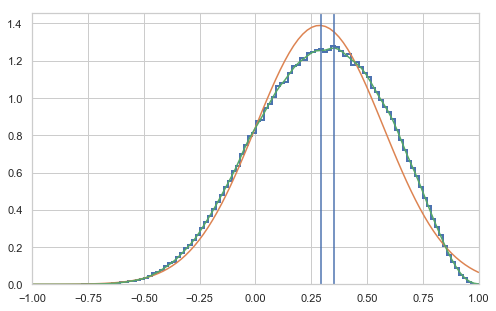

In [19]:
plt.figure(figsize=(8,5))
plt.xlim(-1, 1)

_ = plt.hist(ds['nytimes.com'], histtype='step', bins=100, linewidth=2, normed=True)
plt.plot(x, y_param, label='param')
plt.plot(x, y_nparam, label='nparam')

plt.axvline(mode_param)
plt.axvline(mode_nparam)

In [20]:
def mode_kde(ds, bins=100):
    x = np.linspace(-1, 1, bins)
    kde_density = stats.kde.gaussian_kde(ds)
    y_nparam = kde_density(x)
    return x[np.argsort(y_nparam)[-1]]

In [21]:
mode_kde(ds['buzzfeed.com'])

0.8181818181818183

In [22]:
rows = []
for domain, dds in ds.items():
    for d in dds:
        rows.append((domain, d))

In [23]:
ds_df = pd.DataFrame(rows, columns=('domain', 'd'))

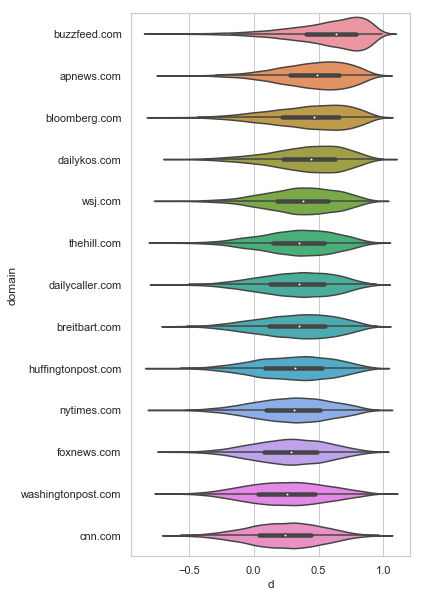

In [24]:
order = ds_df.groupby('domain').mean().sort_values('d', ascending=False).index
plt.figure(figsize=(5,10))
sns.violinplot(y='domain', x='d', data=ds_df.sample(frac=0.01), order=order)

In [25]:
rows = []
for domain, dds in tqdm(ds.items()):
    rows.append((domain, 'mean', np.mean(dds)))
    rows.append((domain, 'median', np.median(dds)))
    rows.append((domain, 'mode', mode_kde(dds)))
    rows.append((domain, 'variance', np.var(dds)))
    rows.append((domain, 'kurtosis', stats.kurtosis(dds)))
    rows.append((domain, 'skew', stats.skew(dds)))

100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


In [26]:
metrics_df = pd.DataFrame(rows, columns=('domain', 'metric', 'value'))

mean


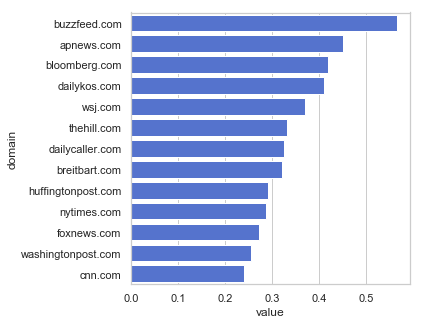

median


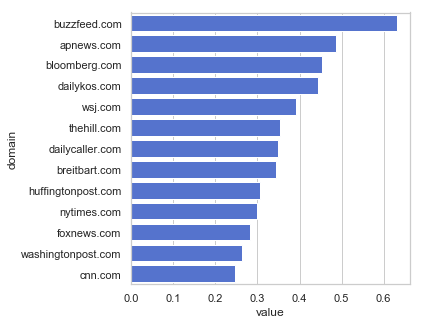

mode


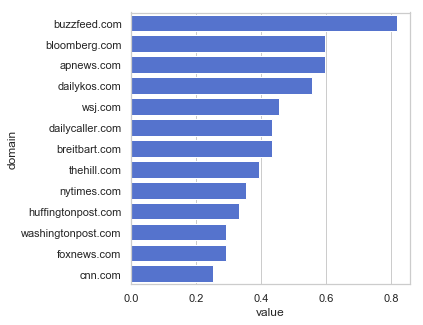

variance


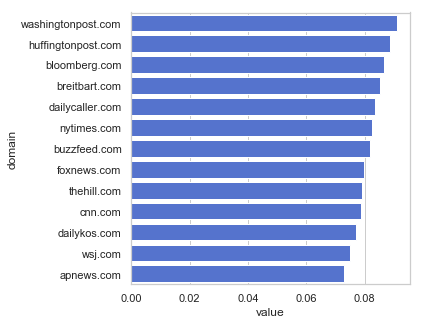

kurtosis


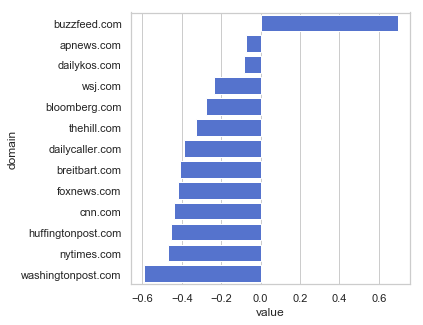

skew


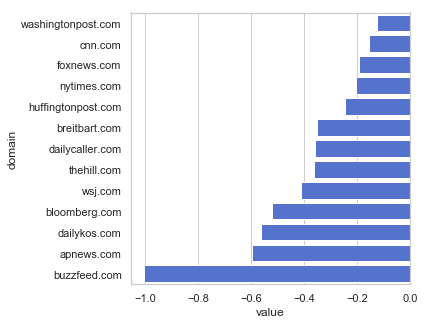

In [27]:
for metric in metrics_df.metric.unique():
    
    mdf = metrics_df[metrics_df.metric==metric].sort_values('value', ascending=False)
    
    print(metric)
    plt.figure(figsize=(5,5))
    sns.barplot(x='value', y='domain', data=mdf, color='RoyalBlue')
    plt.show()